In [306]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader

In [307]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [308]:
class Dataset(torch.utils.data.DataLoader):
  def __init__(self, start, stop, steps, noise=0.1):
    self.x = np.random.uniform(start, stop, steps)
    self.y = np.sin(self.x) / self.x - self.x / 10
    self.func = self.y + self.y.std() * np.random.normal(-noise, noise, steps)
    self.data = np.c_[self.x, self.func]

  def __getitem__(self, idx):
    return self.data[idx]
  
  def __len__(self):
    return self.x.shape[0]

  def MakeGraphics(self):
    idx = self.x.argsort()
    plt.plot(self.x[idx], self.y[idx], color='red', label='target_func')
    plt.scatter(self.x, self.func, color='grey', label='with_noise')
    plt.legend()
    plt.show()

In [309]:
start = -10
stop = 10
steps = 1000
noise = 0.2
batch_size = 32

In [310]:
dataset = Dataset(start, stop, steps, noise)

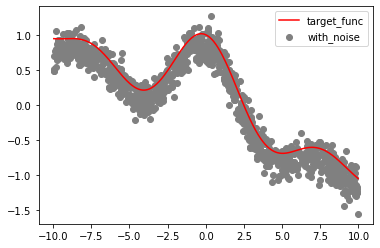

In [311]:
dataset.MakeGraphics()

In [312]:
data = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [313]:
dataiter = iter(data)
label = dataiter.next()
print(label.shape)
print(label)

torch.Size([32, 2])
tensor([[ 4.1702, -0.7016],
        [-8.5581,  0.8148],
        [-3.4030,  0.2600],
        [-8.4200,  0.9126],
        [-9.4336,  0.8006],
        [-1.6846,  0.5465],
        [ 8.8265, -0.9332],
        [ 6.7364, -0.6770],
        [ 0.5603,  0.4419],
        [-8.8892,  0.9190],
        [ 3.5805, -0.6101],
        [ 5.2069, -0.6502],
        [-2.8964,  0.1075],
        [-2.0825,  0.6550],
        [-9.7628,  0.6457],
        [-1.5058,  0.6989],
        [ 8.6808, -1.0887],
        [ 4.0034, -0.8714],
        [-8.1394,  0.8252],
        [ 2.4331, -0.2520],
        [-9.0658,  0.7553],
        [-4.9834,  0.2399],
        [ 7.1431, -0.8184],
        [ 9.1539, -0.6582],
        [ 0.5026,  0.7744],
        [ 2.4618, -0.2480],
        [-5.7387,  0.3221],
        [-0.2920,  0.9568],
        [ 1.9718,  0.1443],
        [-9.3091,  0.6610],
        [ 8.2149, -0.9669],
        [-7.7056,  0.7781]], dtype=torch.float64)


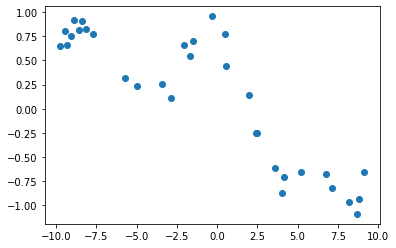

In [314]:
plt.scatter(label[:,0], label[:,1])

In [315]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(2, 128, activation='relu', normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='relu'),
            *block(256, 128, activation='relu'),
            nn.Linear(128, 2))

    def forward(self, x):
        return self.model(x)

In [316]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.activations = nn.ModuleDict([
            ['leaky_relu',nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()],
            ['sigmoid', nn.Sigmoid()]
            ])

        self.model = torch.nn.Sequential(
            *self.block(2, 128, 'leaky_relu'),
            *self.block(128, 256, 'leaky_relu'),
            *self.block(256, 128, 'leaky_relu'),
            *self.block(128, 1, 'sigmoid'),
        )

    def block(self, in_dim, out_dim, activation, normalize=False):
          layers = [torch.nn.Linear(in_dim, out_dim), self.activations[activation]]
          if normalize:
            layers.append(torch.nn.BatchNorm1d(out_dim))
          return layers

    def forward(self, x):
        return self.model(x)

In [317]:
n_epochs = 20  # количество эпох
lr = 0.0001  # шаг обучения
b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

In [318]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [319]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

In [320]:
adversarial_loss = torch.nn.BCELoss()
d_loss_history = []
g_loss_history = []

In [321]:
generator.train()
discriminator.train()

Discriminator(
  (activations): ModuleDict(
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (model): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [322]:
for epoch in range(n_epochs):
  progress = tqdm(data, desc= f'Epoch: {epoch+1} / {n_epochs}' )
  for batch in progress:
        # генерируем метки положительного и отрицательного класса
        valid = torch.FloatTensor(batch.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch.shape[0], 1).fill_(0.0).to(device)
                                                         
        # получаем истинные значения
        true_data = batch.type(torch.FloatTensor).to(device)
        
        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch.shape[0], 2))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(true_data)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
       
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
  
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss_history.append(d_loss.item())
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch.shape[0], 2))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        g_loss_history.append(g_loss.item())

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        progress.set_postfix({'GLOSS': g_loss.item(), 'DLOSS': d_loss.item()})


Epoch: 20 / 20: 100%|██████████| 32/32 [00:00<00:00, 102.51it/s, GLOSS=0.73, DLOSS=0.696]


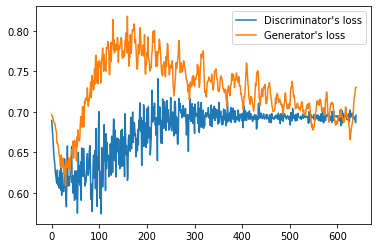

In [323]:
plt.plot(d_loss_history, label="Discriminator's loss")
plt.plot(g_loss_history, label="Generator's loss")
plt.legend()
plt.show()